<a href="https://colab.research.google.com/github/notanhour/denoise/blob/main/blur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from PIL import Image as im
from matplotlib import colors
import numpy as np
import requests

Задаем цвет

In [12]:
def set_color(color: str):
    try:
        color = [int(x) for x in (color, color, color)]
    except ValueError:
        color = [int(x * 255) for x in colors.to_rgb(color)]
    return color

Создаем ядро размытия

In [13]:
def gaussian_kernel(size: int, sigma=1.0):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernel[size // 2, size // 2] = 0  # центр - 0, чтобы не брать в расчет текущий пиксель
    return kernel / np.sum(kernel)  # нормализуем ядро

Помечаем плохие пиксели

In [14]:
def mark(image, bound):
    return abs(np.sum(image, 2) - bound) < 20

Замываем плохие пиксели

In [15]:
def blur_bad_pixels(image, marked, radius: int):
    if not np.sum(marked):  # если 'плохих' пикселей нет
        return image  # просто возвращаем изображение без изменений
    kernel_size = radius * 2 + 1  # размер ядра
    sigma = 1.0  # параметр Гаусса
    kernel = gaussian_kernel(kernel_size, sigma)
    altered_image = image.copy().astype(np.float32)
    for channel in range(3):  # работаем с каналами RGB по очереди
        padded_image = np.pad(image[:, :, channel], pad_width=kernel_size // 2, mode='reflect')
        padded_marked = np.pad(marked, pad_width=kernel_size // 2, mode='reflect')
        altered_channel = np.zeros_like(image[:, :, channel], dtype=np.float32)
        for i in range(image.shape[0]):  # проходим по всем пикселям
            for j in range(image.shape[1]):
                window = padded_image[i:i + kernel_size, j:j + kernel_size]  # извлекаем окно и маску
                mask = ~padded_marked[i:i + kernel_size, j:j + kernel_size]
                weighted_window = window * kernel * mask  # берем значения только 'хороших' пикселей
                weight_sum = np.sum(kernel * mask)
                altered_channel[i, j] = np.sum(weighted_window) / weight_sum if weight_sum > 0 else image[i, j, channel]  # считаем новое значение пикселя (среднее только по 'хорошим')
        altered_image[:, :, channel] = altered_channel
    image[marked] = altered_image[marked].astype(np.uint8)  # меняем только 'плохие' пиксели

---

Загрузка фото

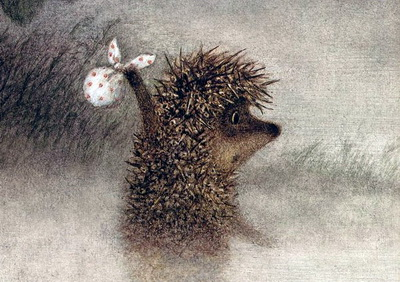

In [16]:
# image = im.open("test.png").convert("RGB")  # локально
url = requests.get("https://ic.pics.livejournal.com/osdru/28368153/14310/14310_original.jpg", stream=True)  # url
image = im.open(url.raw).convert("RGB")  # ...
width, height = image.size
array = np.array(image)  # изображение в массив (r, g, b)
image  # image.show()

Если на фото есть шум, то какого он цвета?

In [ ]:
color = set_color(input("Цвет шума: "))

Если его нет, то добавим!

Количество шума: 50
Цвет шума: red
Шум там, где (r + g + b) < 540


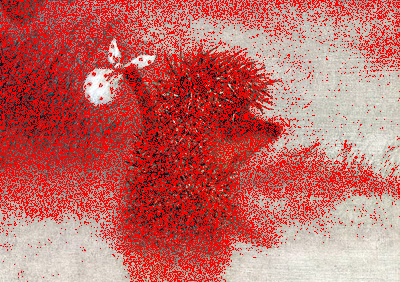

In [17]:
level = int(input("Количество шума: "))  # [0, 100]
color = set_color(input("Цвет шума: "))
maxi = int(input("Шум там, где (r + g + b) < "))
noise = np.random.random(array.shape[:2]) < (level / 100)
rgb = np.sum(image, 2)  # сумма (r, g, b)
array[noise & (rgb < maxi)] = color
image = im.fromarray(array)
image  # image.show()

Долой его!

In [18]:
radius = int(input("Радиус размытия: "))
bound = sum(color)  # шум в районе этого значения
marked = mark(array, bound)
blur_bad_pixels(array, marked, radius)  # передаем по ссылке

Радиус размытия: 2


Показать результат

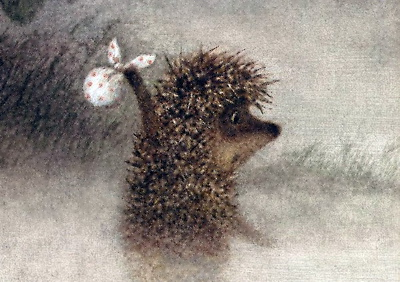

In [19]:
image = im.fromarray(array)  # массив в изображение
image  # image.show()